In [46]:
# === Modules import === # 
!pip install cumulator
import os
import math
import pickle
from pathlib import Path
from cumulator import base
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm

In [47]:
class Net(nn.Module):
    """
    This class, subclass of nn.module, represents the neural network we're using for our task.
    We use 3 convolutinnal layer and 2 functions in our model.
    """
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


class GradientStocker:
    """
    This class is the abstraction to store the different gradients of a neural network
    As a neural networks has more than a unique gradient, we take the gradients of the loss function with respect to each weights and biases and store them in a dictionary. 
    We then use this abstraction to add values in the different gradients, to get the gradients value, and to compute the distance between `agent gradients' for Weight Erosion
    """
    def __init__(self, model_names):
        """Initialize the class by creating the entries in the dictionary"""
        for item in model_names:
            setattr(self, item, 0)

    def get_attributes(self):
        """Returns the gradient's value and attributes"""
        return self.__dict__

    def add_gradient(self, model):
        """Add a value to the already existing gradient        """
        for name, param in model.named_parameters():
            setattr(self, name, getattr(self, name) + param.grad.data.cpu())

    def euclidian_distance(self, grad_current_agent):
        """Computes the relative euclidean distance of the flattened tensor between the current model and the global model"""
        flattened_grad_selected = self.flatten(list(self.get_attributes().values()))
        flattened_grad_current = self.flatten(list(grad_current_agent.get_attributes().values()))
        return torch.dist(flattened_grad_selected, flattened_grad_current, 2) / torch.norm(flattened_grad_selected, 2)

    def flatten(self, gradient_list):
        """Returns an aggregated tensor of all the gradients for one model"""
        gradients = list(map(lambda g : torch.flatten(g), gradient_list))
        return torch.cat(gradients, 0)


def client_update(client_model, optimizer, train_loader, epoch=5):
    """
    Train a client_model on the train_loader data.
    We use local SGD for optimization purposes (Report - III) )
    """
    model_names = []
    for name, param in client_model.named_parameters():
        model_names.append(name)
    gradient_stocker = GradientStocker(model_names)
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            gradient_stocker.add_gradient(client_model)
    return loss.item(), gradient_stocker


def weighted_average_gradients(gradients, weights):
    """Compute the weighted average gradient."""
    weighted_averages = {}
    for key in gradients[0].get_attributes().keys():
        weighted_averages[key] = weighted_average_from_key(key, gradients, weights)
    return weighted_averages

def weighted_average_from_key(key, gradients, weights):
    """Get the weighted average for the gradient of the key"""
    n = 0
    d = 0 
    for idx, g_dict in enumerate(gradients) :
        n += g_dict.get_attributes()[key] * weights[idx]
        d += weights[idx]
    return n / d

def compute_weight(alpha_prev, round, relative_distance, data_size, batch_size, distance_penalty, size_penalty):
    """ 
    Computes the weight alpha for round r
    The mathematical formula is present in our report, section II equation (2)
    """
    size_factor = (1 + size_penalty * math.floor(((round - 1) * batch_size) / data_size)) 
    distance_factor = distance_penalty * relative_distance
    alpha = alpha_prev - size_factor * distance_factor 
    return max(0,alpha)

def update_grad(model, gradient, lr): 
    """ Perform a gradient descent for all the gradients"""
    for name, param in model.named_parameters():
        param.data -= gradient[name].cuda() * lr
    return model 

def share_weight_erosion_model(shared_model, client_models):
    """Share the computed model with all agents"""
    for model in client_models:
        model.load_state_dict(shared_model.state_dict())

def evaluate(global_model, data_loader):
    """Compute loss and accuracy of a model on a data_loader."""
    global_model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.cuda(), target.cuda()
            output = global_model(data)
            loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= len(data_loader.dataset)
    acc = correct / len(data_loader.dataset)

    return loss, acc

In [48]:
# === Run our model training using the Weight Erosion aggregation scheme === # 

def run_weight_erosion(train_loader, test_loader, num_clients, batch_size,
                       selected_agent_index, num_rounds, epochs, distribution, distribution_name='distribution'):
    """This function implements the weight erosion scheme for neural networks"""
    
    # As explained in our paper, we found out that the best distance penalty was 0.1/num_clients, and the size penalty does not matter too much in our case.
    distance_penalty = 0.1/num_clients
    size_penalty = 2
    dataPickle = []

    print("=== Weight Erosion ===")
    
    # We have to store the values corresponding to the best test score
    np.set_printoptions(precision=3)
    acc_best = 0
    round_best = 0
    weight_best = [0.1,0,0,0,0,0,0,0,0,0]

    # Instantiate models and optimizers
    shared_model = Net().cuda()
    client_models = [Net().cuda() for _ in range(num_clients)]
    for model in client_models:
        model.load_state_dict(shared_model.state_dict())
    opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

    # Initialize our grad vector to None as there is no grad yet, and our weight vector as 1
    grad_vector = [None for _ in range(num_clients)]
    weight_vector = np.ones(num_clients)

    for r in range(num_rounds):

        print('%d-th round' % r)

        # Client update: computation of the gradients of the client, of its relative distance to the selected agent, and its new weight vector.
        loss = np.zeros(num_clients)
        for i in range(num_clients):
            loss[i], grad_vector[i] = client_update(client_models[i], opt[i], train_loader[i], epoch=epochs)
            d_rel = grad_vector[selected_agent_index].euclidian_distance(grad_vector[i])
            weight_vector[i] = compute_weight(weight_vector[i], r + 1, d_rel, len(train_loader[i]), batch_size, distance_penalty, size_penalty)


        # Computation of the personalized model
        weighted_mean_gradient = weighted_average_gradients(grad_vector, weight_vector)
        shared_model = update_grad(shared_model, weighted_mean_gradient, 0.1)

        # Share model to all agents
        share_weight_erosion_model(shared_model, client_models)

        # Evalutate on the agent's test set 
        test_loss, acc = evaluate(shared_model, test_loader)


        print(f'Weight : {weight_vector}')
        print(f'Loss   : {loss}')
        print(f'Test loss {test_loss:.3f} | Test acc: {acc:.3f} \n')
        
        # Keep the accuracy for each round 
        dataPickle.append([acc,test_loss,loss[selected_agent_index], sum(weight_vector)/num_clients])
        
        # Update the best accuracy 
        if acc > acc_best:
            acc_best = acc
            round_best = r+1
            weight_best = weight_vector
    
    # Stores the important informations for each round
    with open(Path.cwd()/'generated'/'pickles'/f'weight_erosion_{num_clients}_{distribution_name}.pickle', 'wb') as f:
        pickle.dump(dataPickle, f)

    return [acc_best, round_best, weight_best]


In [49]:
# === Run our model training using the Federated Average aggregation scheme === # 

def run_federated(train_loader, test_loader, num_clients,batch_size, 
                  selected_agent_index, num_rounds, epochs, distribution, distribution_name='distribution'):
    """This function implements federated average aggregation scheme for neural network. We used the same system as WE scheme, but we kept the weigh equal all the time"""
    
    print("=== Federated ===")
    # We have to store the values corresponding to the best test score
    np.set_printoptions(precision=3)
    acc_best = 0
    round_best = 0
    dataPickle = []

    # Instantiate models and optimizers
    shared_model = Net().cuda()
    client_models = [Net().cuda() for _ in range(num_clients)]
    for model in client_models:
        model.load_state_dict(shared_model.state_dict())
    opt = [optim.SGD(model.parameters(), lr=0.1) for model in client_models]

    
    grad_vector = [None for _ in range(num_clients)]
    weight_vector = np.full(num_clients, 1/num_clients)
    
    for r in range(num_rounds):

        print('%d-th round' % r)

        # Client update
        loss = np.zeros(num_clients)
        for i in range(num_clients):
            loss[i], grad_vector[i] = client_update(client_models[i], opt[i], train_loader[i], epoch=epochs)


        # Weight Erosion Scheme
        weighted_mean_gradient = weighted_average_gradients(grad_vector, weight_vector)
        shared_model = update_grad(shared_model, weighted_mean_gradient, 0.1)

        # Share model to all agents
        share_weight_erosion_model(shared_model, client_models)

        # Evalutate on the agent's test set
        test_loss, acc = evaluate(shared_model, test_loader)

        print(f'Loss   : {loss}')
        print(f'Test loss {test_loss:.3f} | Test acc: {acc:.3f} \n')
        
        # Keep the accuracy for each round 
        dataPickle.append([acc,test_loss,loss[selected_agent_index]])
        
        # Update the best accuracy 
        if acc > acc_best:
            acc_best = acc
            round_best = r+1
    
    # Stores the important informations for each round in a pickle file
    with open(Path.cwd()/'generated'/'pickles'/f'federated_{num_clients}_{distribution_name}.pickle', 'wb') as f:
        pickle.dump(dataPickle, f)
        
    return [acc_best, round_best]


In [50]:
# === Run our model training Locally === # 

def run_local(train_loader, test_loader, num_clients, batch_size, 
              selected_agent_index, num_rounds, epochs, distribution, distribution_name='distribution'):
    """This function implements local training for neural network. We use the same scheme as Federated average, but we train only for the selected agent index"""
    
    print("=== Local ===")
    np.set_printoptions(precision=3)
    dataPickle = []

    # Instantiate models and optimizers
    client_model = Net().cuda()
    opt = optim.SGD(client_model.parameters(), lr=0.1) 
        
    acc_best = 0
    round_best = 0
    
    for r in range(num_rounds):
        
        print('%d-th round' % r)
        
        # Client update
        train_loss, grad_stocker = client_update(client_model, opt, train_loader[selected_agent_index], epoch=epochs)

        # Evalutate on the selected agent's test set 
        test_loss, acc = evaluate(client_model, test_loader)
        
        # Print the results 
        print(f'Loss   : {train_loss}')
        print(f'Test loss {test_loss:.3f} | Test acc: {acc:.3f} \n')
        
        # Keep the accuracy for each round 
        dataPickle.append([acc,test_loss,train_loss])
        
        # Update the best accuracy 
        if acc > acc_best:
            acc_best = acc
            round_best = r+1
            
    with open(Path.cwd()/'generated'/'pickles'/f'local_{num_clients}_{distribution_name}.pickle', 'wb') as f:
        pickle.dump(dataPickle, f)

    return [acc_best, round_best]

In [51]:
# === Distribution functions === # 


def get_non_iid_loader_distribution(num_clients,batch_size,distribution,selected_agent_index, validation_size=0.1):
    """Get the train and test set based on a specific distribution """
    
    # Get train and test data of MNIST_
    traindata = datasets.MNIST('./data', train=True, download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))
    testdata = datasets.MNIST('./data', train=False, download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

    # Find data for each targets value [0,1,..,9]. We do this for train and test set
    target_labels = torch.stack([traindata.targets == i for i in range(10)])
    target_labels_test = torch.stack([testdata.targets == i for i in range(10)])
    target_labels_split = []
    target_labels_split_test = []

    # Divide each target labels in small samples
    target_label_division = 100 # Number of samples for each digits
    for i in range(10):
        target_labels_data = torch.where(target_labels[i])[0]    # We get the train data for the current target value (i)
        target_labels_data_test = torch.where(target_labels_test[i])[0] # We get the test data for the current target value (i)

        # Split data in 100 (target_label_division) subsamples
        target_labels_split += torch.split(target_labels_data, int((len(target_labels_data)) / (target_label_division-1)))
        target_labels_split_test += torch.split(target_labels_data_test, int((len(target_labels_data_test))))

        target_labels_split = target_labels_split[:target_label_division*(i+1)] # Sometimes we get more than 100 values (the digits do not have th exact same amount). We take the first 100 samples.
    
    # We now have 10 (unique targets values) * 100 (subsample for each target value) = 1000 samples

    # Merge selected samples for each client based on the distribution
    savedDistribution = distribution
    distribution = [target_label_division * x / (max(num_clients,10)/10) for x in distribution] # Adapt the initial distribution depending on the number of sample and number of clients
    samples_used = [0,0,0,0,0,0,0,0,0,0]
    next_samples_used = [0,0,0,0,0,0,0,0,0,0]
    split_client = []
    test_data = torch.tensor([],dtype=torch.long)

    # Add data for each clients
    for i in range(num_clients):
        split_client.append(torch.tensor([],dtype=torch.long))

        # The array sample_used represent where we actually are in the different samples
        # Distribution represent the distribution of our current client
        # Thus, to get the next sample to use, we have to add samples_used and distribution, for each digits
        for n in range(10):
            next_samples_used[n] = samples_used[n] + distribution[n]

        # Update the distribution by shifting to the left after each clients
        distribution = distribution[1:] + distribution[:1]
        
        # For each digits
        for number in range(10): 
            # Add data to the Test loader if it's the good client
            if i == selected_agent_index and samples_used[number] < next_samples_used[number]:
                # Get the size of the two chunks
                sizeDataTest = int(savedDistribution[number] * len(target_labels_split_test[number]))
                sizeDataTestLeft = len(target_labels_split_test[number]) - sizeDataTest
                
                # Split the data to get the same distribution as the train set, then stores the data in test_data
                t1, t2 = torch.split(target_labels_split_test[number], [sizeDataTest,sizeDataTestLeft])
                test_data = torch.cat((test_data, t1),0)

            # Add data to train set, as long as we can do it
            while samples_used[number] < next_samples_used[number]: 
                # Get the first value for our digit by doing the computation number * number of chunks per digit + current sample for our number
                # Ex: We compute, for the number 8 if we are currently at the 43 value: 8 * 100 + 43 = 843
                begining_chunk_target_value = number*target_label_division
                id_data_available = begining_chunk_target_value+samples_used[number]
                split_client[i] = torch.cat((split_client[i], target_labels_split[id_data_available]),0)
                samples_used[number] += 1
            
            # Security if the sum of distribution > 1 (which should not be the case)
            if samples_used[number] > next_samples_used[number]:
                samples_used[number] -= 1

    # Split the data in test and train loader
    traindata_split = [torch.utils.data.Subset(traindata, tl) for tl in split_client]
    testdata_split = torch.utils.data.Subset(testdata, test_data)
    train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]
    test_loader = torch.utils.data.DataLoader(testdata_split, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

def get_iid_loader(num_clients,batch_size):
    """Get a i.i.d test set and train set"""
    traindata = datasets.MNIST('./data', train=True, download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))
    traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in range(num_clients)])
    train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]
    test_loader = torch.utils.data.DataLoader(datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])), batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

def get_iid_loader_with_validation(num_clients, batch_size, validation_size=0.1):
    """Get i.i.d data with validation set"""
    traindata = datasets.MNIST('./data', train=True, download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))
    testdata = datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))]))

    traindata_split = torch.utils.data.random_split(traindata, [int(traindata.data.shape[0] / num_clients) for _ in range(num_clients)])
    testdata_split = torch.utils.data.random_split(testdata, [int(testdata.data.shape[0] / num_clients) for _ in range(num_clients)])

    train_loader = []
    validation_loader = []

    for x in traindata_split:
        x_size = len(x)
        size_train = int(math.ceil(x_size * (1 - validation_size)))
        size_validation = int(math.floor(x_size * validation_size))
        train_set, validation_set = torch.utils.data.random_split(x, [size_train, size_validation])

        train_loader.append(torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True))
        validation_loader.append(torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=True))

    test_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in testdata_split]


    return train_loader, validation_loader, test_loader


def get_non_IID_loader_digit_pairs(num_clients,batch_size):
    """Generates train and test loader for digits pairs (0, 1), (2, 3), (4, 5), (6, 7), (8, 9)"""
    traindata = datasets.MNIST('./data', train=True, download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))
    testdata = datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

    train_target_labels = torch.stack([traindata.targets == i for i in range(10)])
    test_target_labels = torch.stack([testdata.targets == i for i in range(10)])

    train_split_size = int(60000 / num_clients)
    test_split_size = int(10000 / num_clients)

    train_target_labels_split = []
    test_target_labels_split = []

    for i in range(num_clients):
        train_target_labels_split += torch.split(torch.where(train_target_labels[(2 * i):(2 * (i + 1))].sum(0))[0][:train_split_size], train_split_size)
        test_target_labels_split += torch.split(torch.where(test_target_labels[(2 * i):(2 * (i + 1))].sum(0))[0][:test_split_size], test_split_size)

    traindata_split = [torch.utils.data.Subset(traindata, tl) for tl in train_target_labels_split]
    testdata_split = [torch.utils.data.Subset(testdata, tl) for tl in test_target_labels_split]

    train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]
    test_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in testdata_split]

    return train_loader, test_loader


def generate_permutations(nb_agents=5, sample_size=3):
    """
    Generate random permutations with sample_size digits for each agents (number of agents = nb_agents)
    It ensures that each digits is assigned at least once
    """
    available_labels = np.array([0,1,2,3,4,5,6,7,8,9])
    triplets = {}

    valid = False
    while not valid :
        all_digits = []
        for i in range(nb_agents):
            triplets[i] = np.random.choice(available_labels,sample_size,replace=False)
            all_digits.extend(triplets[i])
        valid = len(np.unique(all_digits)) == len(available_labels)
    
    return triplets


def get_non_IID_loader_digit_trios(num_clients,batch_size):
    """Get train and test loader for random trios of digits"""
    traindata = datasets.MNIST('./data', train=True, download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))
    testdata = datasets.MNIST('./data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

    train_target_labels = torch.stack([traindata.targets == i for i in range(10)])
    test_target_labels = torch.stack([testdata.targets == i for i in range(10)])

    train_split_size = int(60000 / num_clients)
    test_split_size = int(10000 / num_clients)

    train_target_labels_split = []
    test_target_labels_split = []

    triplets = generate_permutations(num_clients)

    for i in range(num_clients):
        i_labels = triplets[i]
        print(f"Agent {i} is assigned labels {i_labels}")
        train_target_labels_split += torch.split(torch.where(train_target_labels[i_labels].sum(0))[0][:train_split_size], train_split_size)
        test_target_labels_split += torch.split(torch.where(test_target_labels[i_labels].sum(0))[0][:test_split_size], test_split_size)

    traindata_split = [torch.utils.data.Subset(traindata, tl) for tl in train_target_labels_split]
    testdata_split = [torch.utils.data.Subset(testdata, tl) for tl in test_target_labels_split]

    train_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in traindata_split]
    test_loader = [torch.utils.data.DataLoader(x, batch_size=batch_size, shuffle=True) for x in testdata_split]

    return train_loader, test_loader


In [52]:
# === Run the Benchmarking === #  

# === parameters for the aggregation Schemes === #

selected_agent_index = 0
num_rounds = 30
epochs = 1

# === parameters for training and testing === #

batch_size = 32


# === Benchmarking Parameters === #

# These are all distributions and number of clients on which we are running our algorithms 
distributions = {'A' : [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                 'B' : [0, 0, 0, 0, 0.2, 0.6, 0.2, 0, 0, 0],
                 'C' : [0.25, 0.25, 0.25, 0.25, 0, 0, 0, 0, 0, 0],
                 'D' : [0, 0, 0, 0.4, 0.1, 0, 0.1, 0.4, 0, 0],
                 'E' : [0, 0, 0, 0.1, 0.2, 0.4, 0.2, 0.1, 0, 0],
                 'F' : [0, 0, 0.1, 0.1, 0.2, 0.2, 0.2, 0.1, 0.1, 0],
                 'G' : [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01 ]}

clients = [10, 20, 50, 100]

# We keep track of our computation's carbon footprint
cumulator = base.Cumulator()
cumulator.on()

# Create generated data
results_dir = './generated/pickles'
if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
        
for name, distribution in distributions.items():
    for num_clients in clients:
        print(f' - Number Client {num_clients}, distribution {name}: {distribution}')
        train_loader, test_loader = get_non_iid_loader_distribution(num_clients,batch_size,distribution,selected_agent_index)

        data_pickle = []
        
        # === Run with Weight Erosion aggregation Scheme 
        data_pickle.append(run_weight_erosion(train_loader, test_loader, num_clients, batch_size, selected_agent_index, num_rounds, epochs, distribution, distribution_name=name))

        # === Run Federated Learning aggregation Scheme 
        data_pickle.append(run_federated(train_loader, test_loader, num_clients, batch_size, selected_agent_index, num_rounds, epochs, distribution, distribution_name=name))

        # === Run Local Training 
        data_pickle.append(run_local(train_loader, test_loader, num_clients,batch_size, selected_agent_index, num_rounds, epochs, distribution, distribution_name=name))
        
        # === Store the results as pickles 
        with open(Path.cwd()/'generated'/'pickles'/f'{num_clients}_{name}.pickle', 'wb') as f:
            pickle.dump(data_pickle, f)
            
cumulator.off()
print(f'The total carbon footprint generated by this benchmark is : {cumulator.total_carbon_footprint()} gCO2eq')
        

 - Number Client 10, distribution B: [0, 0, 0, 0, 0.2, 0.6, 0.2, 0, 0, 0]
=== Weight Erosion ===
0-th round
Weight : [1.    0.99  0.989 0.987 0.988 0.988 0.987 0.987 0.988 0.991]
Loss   : [0.046 0.164 0.018 0.023 0.112 0.033 0.036 0.226 0.021 0.027]
Test loss 1.785 | Test acc: 0.674 

1-th round
Weight : [1.    0.98  0.976 0.972 0.975 0.975 0.973 0.973 0.976 0.982]
Loss   : [7.143e-02 1.371e-01 2.478e-01 1.667e-04 1.363e-03 1.090e-03 1.605e-01
 8.504e-02 9.677e-04 1.245e-02]
Test loss 1.134 | Test acc: 0.824 

2-th round
Weight : [1.    0.968 0.963 0.957 0.959 0.961 0.958 0.957 0.963 0.972]
Loss   : [4.198e-02 1.011e-01 1.541e-02 2.534e-04 3.810e-01 5.456e-03 4.741e-03
 3.399e-02 2.189e-02 1.101e-03]
Test loss 0.822 | Test acc: 0.860 

3-th round
Weight : [1.    0.956 0.949 0.943 0.946 0.948 0.943 0.941 0.95  0.963]
Loss   : [0.002 0.007 0.063 0.025 0.003 0.001 0.003 0.024 0.003 0.098]
Test loss 0.573 | Test acc: 0.880 

4-th round
Weight : [1.    0.943 0.935 0.928 0.932 0.935 0.928 0.

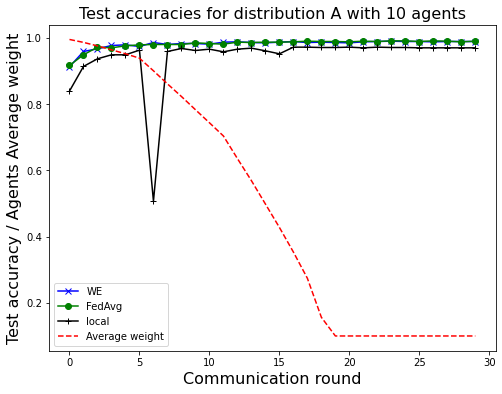

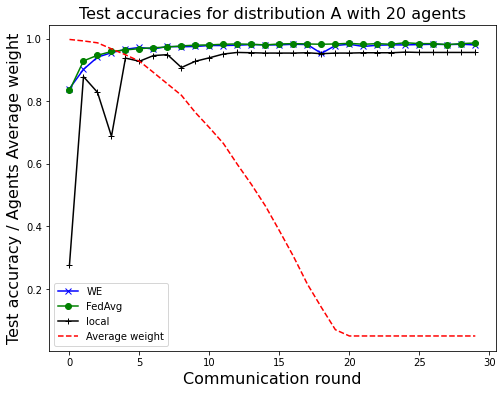

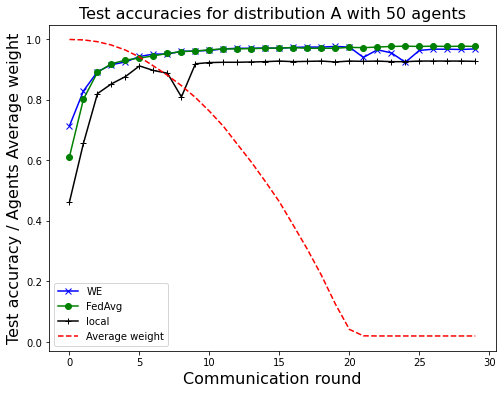

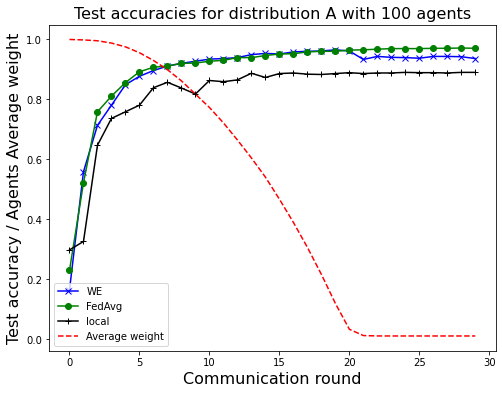

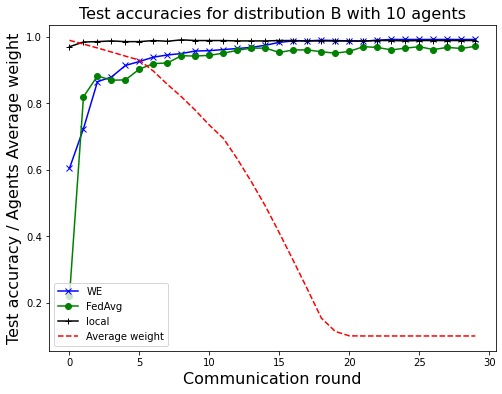

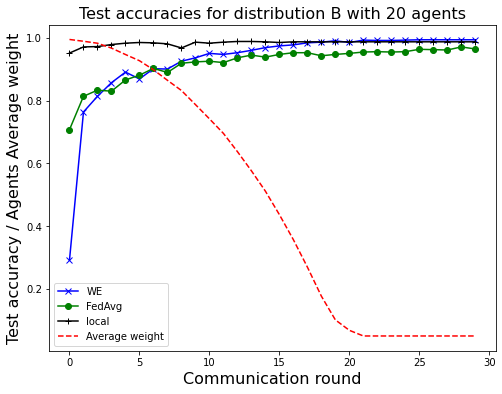

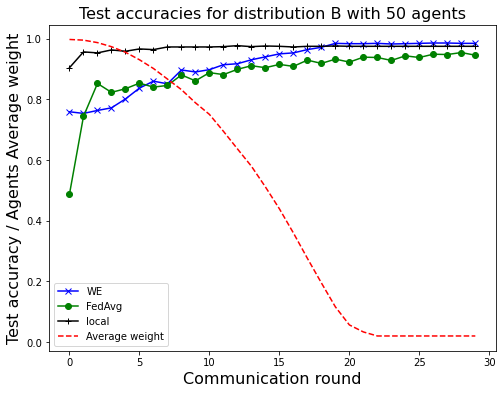

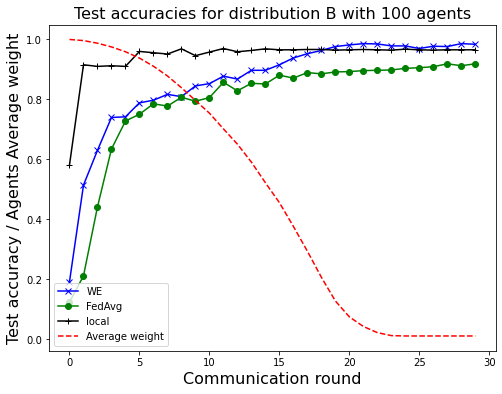

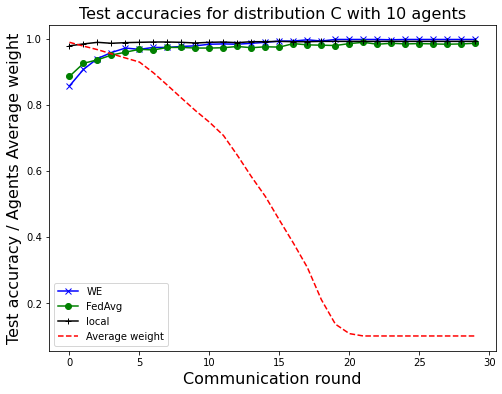

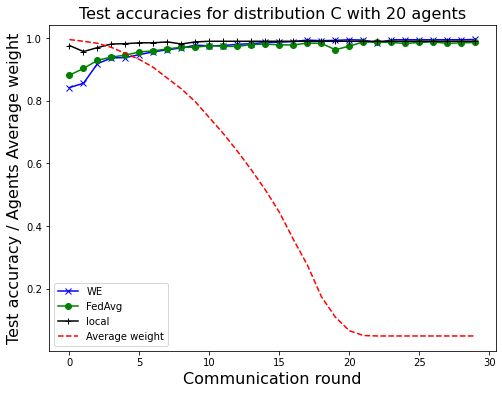

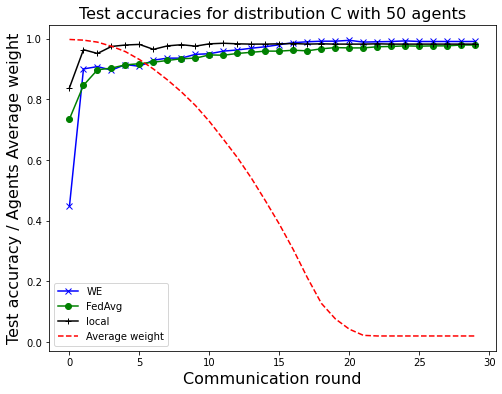

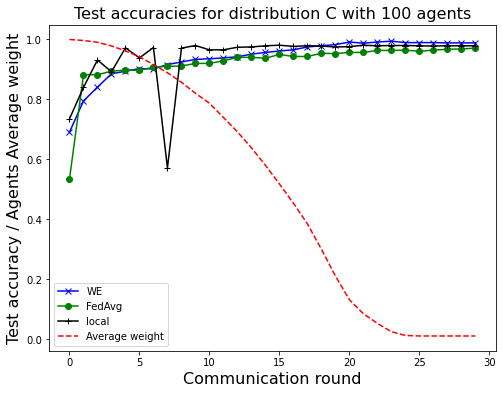

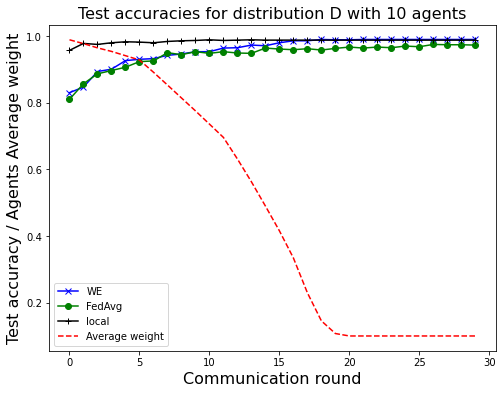

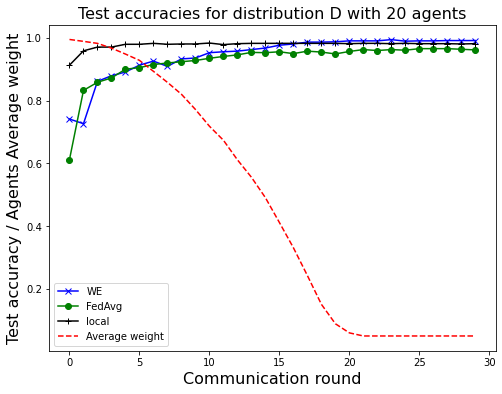

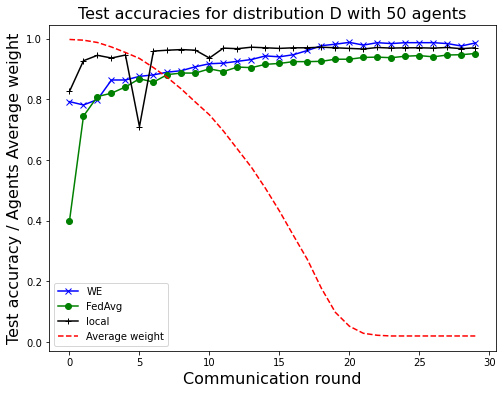

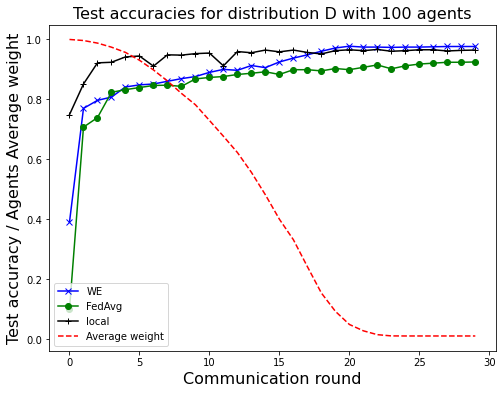

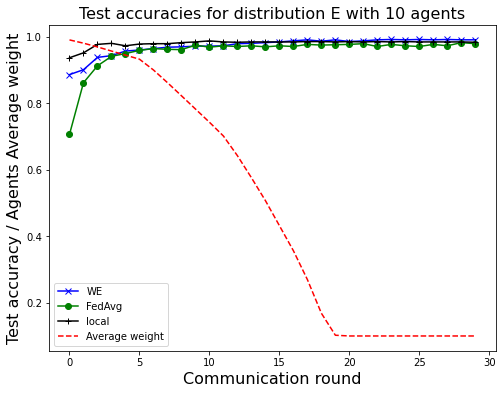

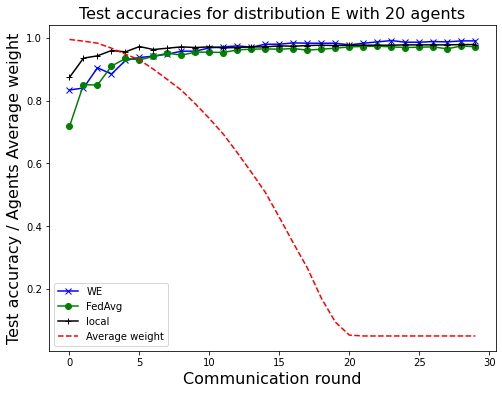

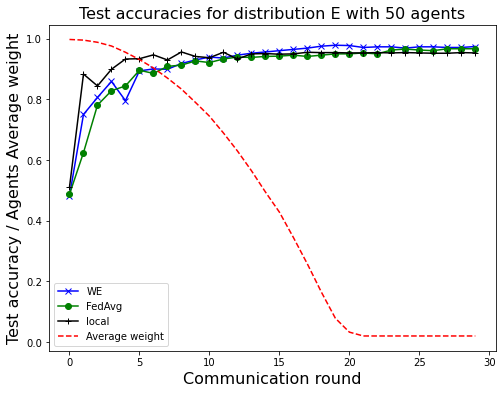

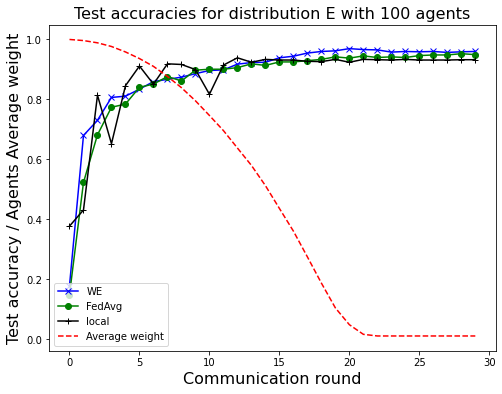

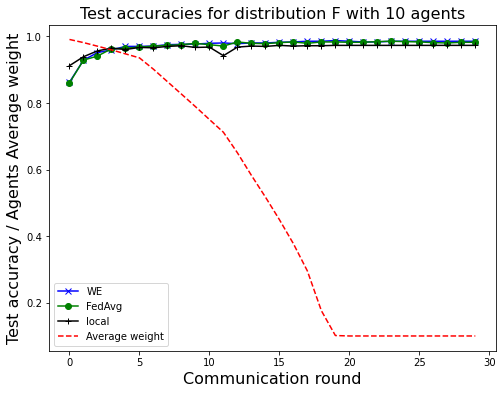

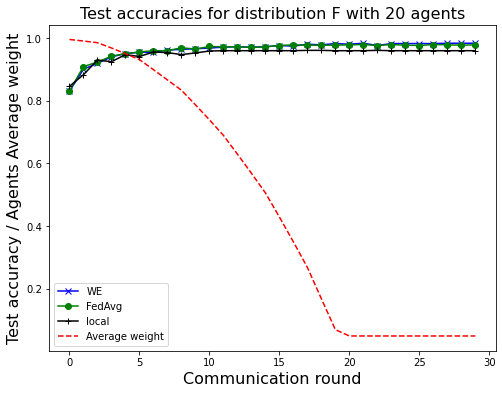

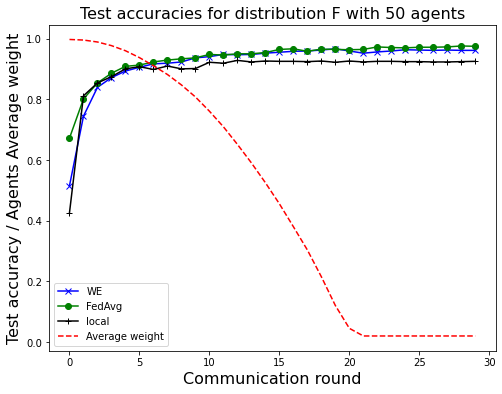

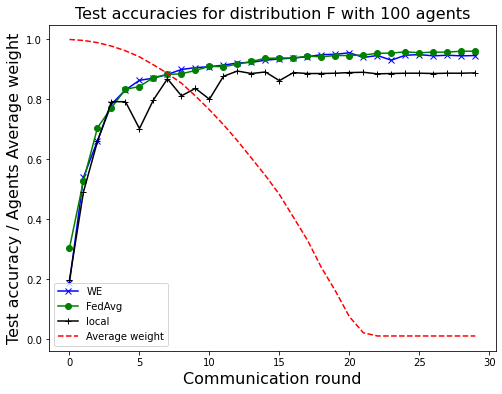

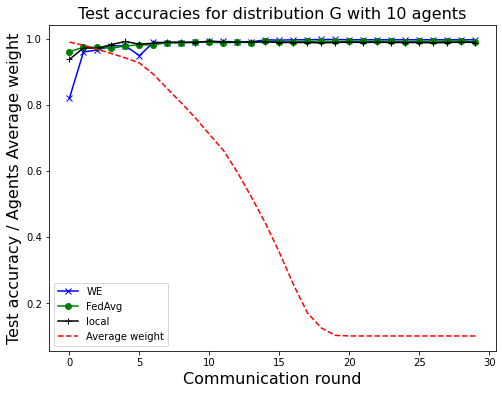

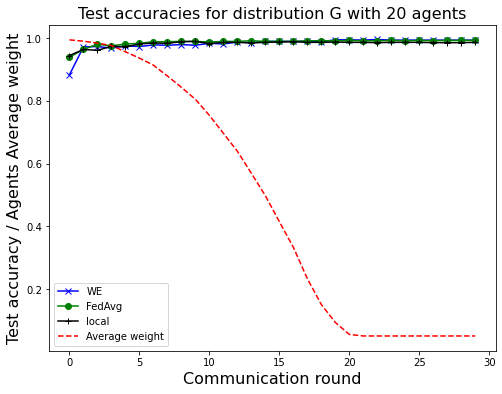

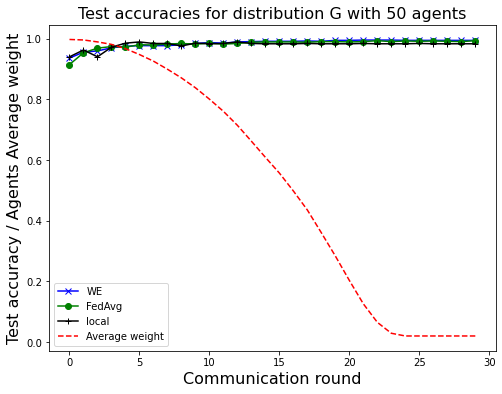

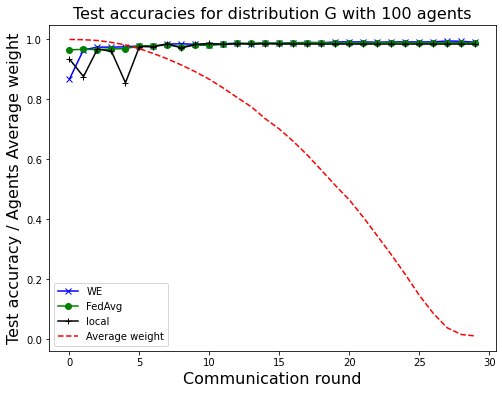

In [9]:
# Plots accuracy for each algorithms for w.r.t. the number of rounds
def plot(nb_round, WE_result, FedAvg_result, local_result, weight_avg, title, file_name):
    plt.figure(num=None, figsize=(8, 6), facecolor='w', edgecolor='k')
    plt.plot(nb_round, WE_result, '-xb', label='WE')
    plt.plot(nb_round, FedAvg_result, '-og', label="FedAvg")
    plt.plot(nb_round, local_result, '-+k', label="local")
    plt.plot(nb_round, weight_avg, color='r', linestyle='dashed', label='Average weight')
    plt.title(title, fontsize=16)
    ax = plt.gca()
    ax.legend(loc=3)
    ax.set_xlabel("Communication round", fontsize=16)
    ax.set_ylabel("Test accuracy / Agents Average weight", fontsize=16)
    
    results_dir = './generated/plots'
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
        
    plt.savefig(Path.cwd()/results_dir/f'{file_name}.png')
    plt.show()
    
def format_for_plot(data, index=0):
    return np.array([d[index] for d in data])

pickles_folder = Path.cwd()/'generated'/'pickles'

def plot_pickled_results(distributions, nb_agents):
    for d_name in distributions.keys():
        for n in nb_agents:
            with open(pickles_folder/f'federated_{n}_{d_name}.pickle', 'rb') as f:
                data_fed = pickle.load(f)
            with open(pickles_folder/f'weight_erosion_{n}_{d_name}.pickle', 'rb') as f:
                data_we = pickle.load(f)
            with open(pickles_folder/f'local_{n}_{d_name}.pickle', 'rb') as f:
                data_local = pickle.load(f)

            nb_round = np.arange(30)
            acc_fed_plot = format_for_plot(data_fed)
            acc_we_plot = format_for_plot(data_we)
            weight_avg = format_for_plot(data_we, 3)
            acc_loc_plot = format_for_plot(data_local)


            plot(nb_round=nb_round, WE_result=acc_we_plot, FedAvg_result=acc_fed_plot, local_result=acc_loc_plot, 
                 weight_avg=weight_avg, title=f'Test accuracies for distribution {d_name} with {n} agents', 
                 file_name=f'results_distribution_{d_name}_{n}_agents')

plot_pickled_results(distributions, clients)

In [8]:
pickles_folder = Path.cwd()/'generated'/'pickles'

def display_benchmark_best_accuracy_restults(distributions, nb_agents):
     for d_name in distributions.keys():
        print(f'#==== Results for Distribution {d_name} ====#\n')
        for n in nb_agents:
            with open(pickles_folder/f'{n}_{d_name}.pickle', 'rb') as f:
                d = pickle.load(f)
            print(f'Test accuracy results for distribution {d_name} with {n} agents\n')
            print(f' - Weight Erosion    : accuracy is {d[0][0]:.4f} achieved at round {d[0][1]} \n')
            print(f' - Federated Average : accuracy is {d[1][0]:.4f} achieved at round {d[1][1]} \n')
            print(f' - Local Training    : accuracy is {d[2][0]:.4f} achieved at round {d[2][1]} \n')
display_benchmark_best_accuracy_restults(distributions, clients)

#==== Results for Distribution A ====#

Test accuracy results for distribution A with 10 agents

 - Weight Erosion    : accuracy is 0.9900 achieved at round 24 

 - Federated Average : accuracy is 0.9910 achieved at round 24 

 - Local Training    : accuracy is 0.9719 achieved at round 17 

Test accuracy results for distribution A with 20 agents

 - Weight Erosion    : accuracy is 0.9819 achieved at round 17 

 - Federated Average : accuracy is 0.9869 achieved at round 25 

 - Local Training    : accuracy is 0.9568 achieved at round 25 

Test accuracy results for distribution A with 50 agents

 - Weight Erosion    : accuracy is 0.9759 achieved at round 20 

 - Federated Average : accuracy is 0.9769 achieved at round 25 

 - Local Training    : accuracy is 0.9277 achieved at round 16 

Test accuracy results for distribution A with 100 agents

 - Weight Erosion    : accuracy is 0.9649 achieved at round 20 

 - Federated Average : accuracy is 0.9709 achieved at round 29 

 - Local Trainin